In [50]:
import numpy as np
from PIL import Image
import time
from numba import cuda
import math
from google.colab.patches import cv2_imshow

In [51]:
img = Image.open('drive/MyDrive/HPC/i.bmp')
gray_img = np.array(img.convert("L"))
print(gray_img.shape)

(320, 255)


In [52]:
@cuda.jit
def kernel(img_input, img_output, d, sr, sd):
  r = d//2
  i, j = cuda.grid(2)
  if i < img_input.shape[0] and j < img_input.shape[1]:
      h = 0
      k = 0
      for ik in range(i - r, i + r + 1):
        for jk in range(j - r, j + r + 1):
          if ik >= 0 and ik < img_input.shape[0] and jk >= 0 and jk < img_input.shape[1]:
            x = ik - i
            y = jk - j
            w = math.exp(-((x**2 - y**2)/(sd**2))) * math.exp(((int(img_input[ik][jk]) - int(img_input[i][j]))**2)/(sr**2))
            h += img_input[ik][jk] * w
            k += w
      img_output[i][j] = h/k

In [53]:
def bilinear_gpu(img_input, d=4, sr=32, sd=32, block_size=(32, 32)):
  grid_size=(math.ceil(img_input.shape[0]/block_size[0]), math.ceil(img_input.shape[1]/block_size[1]))

  device_img_input = cuda.to_device(img_input)
  device_img_output = cuda.to_device(np.zeros(img_input.shape))
  kernel[grid_size, block_size](device_img_input, device_img_output, d, sr, sd)

  return device_img_output.copy_to_host()

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 80 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


GPU time is: 0.3196072578430176


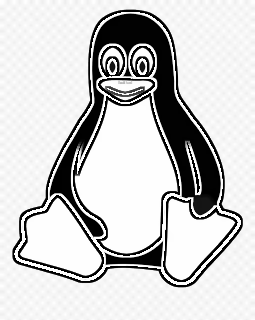

In [54]:
start = time.time()

result = bilinear_gpu(gray_img)

elapsed_time = time.time() - start

print(f"GPU time is: {elapsed_time}")
cv2_imshow(result)

image = Image.fromarray(result.astype(np.uint8))
image.save('img_gpu.png')

In [55]:
def bilinear_cpu(img_input, d=4, sr=32, sd=32, block_size=(32, 32)):
  img_output = np.zeros(img_input.shape)
  r = d//2
  for i in range(img_input.shape[0]):
    for j in range(img_input.shape[1]):
      h = 0
      k = 0
      for ik in range(i - r, i + r + 1):
        for jk in range(j - r, j + r + 1):
          if 0 <= ik < img_input.shape[0] and 0 <= jk < img_input.shape[1]:
            x = ik - i
            y = jk - j
            w = math.exp(-((x**2 - y**2)/(sd**2))) * math.exp(((int(img_input[ik][jk]) - int(img_input[i][j]))**2)/(sr**2))
            h += img_input[ik][jk] * w
            k += w
      img_output[i][j] = h/k
  return img_output

CPU time is: 12.110430240631104


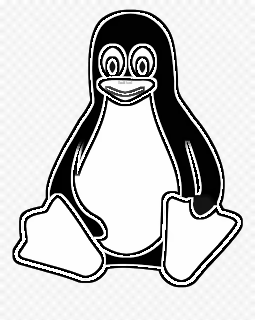

In [56]:
start = time.time()

result_cpu = bilinear_cpu(gray_img)

elapsed_time = time.time() - start

print(f"CPU time is: {elapsed_time}")
cv2_imshow(result_cpu)

image = Image.fromarray(result_cpu.astype(np.uint8))
image.save('img_cpu.png')